In [3]:
import numpy as np
import pandas as pd
from pathlib import Path
from datetime import datetime
import xarray as xr

In [4]:
#Replace with file path for this directory on your machine
!pip install -e /Users/justinmaynard/Documents/GitHub/assetraMP/ 

Obtaining file:///Users/justinmaynard/Documents/GitHub/assetraMP
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Building editable for assetra (pyproject.toml) ... done
  Created wheel for assetra: filename=assetra-1.0.3-py3-none-any.whl size=2689 sha256=dbec1acd386afa31ce06d71424f177f8781dc8432d27f26b9e6f1bc595d1c07a
  Stored in directory: /private/var/folders/zd/3zqsbnbn5lg29wjyl0df33l80000gn/T/pip-ephem-wheel-cache-pqfll3o7/wheels/c0/f5/c9/3b09bf7f2c6beadc5d6cde6ca7e50094804a4b90493c211e80
Successfully built assetra
  Attempting uninstall: assetra
    Found existing installation: assetra 1.0.3
    Uninstalling assetra-1.0.3:
      Successfully uninstalled assetra-1.0.3


In [86]:
p = Path(".")
root_folder = p.cwd().parent
git_data_folder = root_folder  / 'git_data'
gen_data_folder = git_data_folder / 'gen_forecasts' 
scripts_foler = root_folder/ 'scripts'
outside_data_folder = root_folder / 'outside_data'
gen_data_folder = git_data_folder / 'gen_forecasts'
historical_load_data = git_data_folder / 'historical_load'
load_forecast_data = git_data_folder / 'load_forecasts'

scratch_folder = root_folder  / 'scratch'

### Demand Data

In [64]:
#Function to load demand data
def load_pjm_cleaned_hourly_demand(
        pjm_demand_file: Path,
        start_hour: datetime,
        end_hour: datetime) -> xr.DataArray:
    """Return hourly demand data as formatted data array.
    To use this function, download cleaned demand data from:

    https://github.com/truggles/EIA_Cleaned_Hourly_Electricity_Demand_Data

    Args:
        eia_930_cleaned_demand_file (Path): Path to hourly demand file
        start_hour (datetime): First timestamp to include
        end_hour (datetime): Last timestamp to include (inclusive)

    Returns:
        xr.DataArray: Hourly demand array with time dimension and datetime coordinates.
    """
    # read demand file
    pjm_demand_df = pd.read_csv(
        pjm_demand_file,
        usecols=["datetime_beginning_ept", "mw"],
        index_col="datetime_beginning_ept",
        parse_dates=True,
    )

    # remove leap day
    #pjm_demand_df = pjm_demand_df[~((pjm_demand_df.index.month == 2) & (pjm_demand_df.index.day == 29))]


    # keep cleaned demand demand
    pjm_hourly_demand_pd = pjm_demand_df["mw"].loc[start_hour:end_hour]

    # convert to xr.DataArray
    pjm_hourly_demand = xr.DataArray(
        data=pjm_hourly_demand_pd.values,
        coords=dict(
            time=pjm_hourly_demand_pd.index.values
        )
    )
    return pjm_hourly_demand

In [65]:
#Load demand data
pjm_cleaned_demand_file = Path( historical_load_data /  "pjm_load_2020.csv")
hourly_demand = load_pjm_cleaned_hourly_demand(
	pjm_cleaned_demand_file,
	start_hour="2020-01-01 00:00:00",
	end_hour="2020-12-31 23:00:00"
)

In [66]:
from assetra.system import EnergySystem
from assetra.system import EnergySystemBuilder

builder = EnergySystemBuilder()
unit_count = 0


In [67]:
# create demand unit
from assetra.units import DemandUnit

builder.add_unit(
    DemandUnit(
        id=unit_count,
        hourly_demand=hourly_demand
    )
)
unit_count += 1

### EIA 860 Data

In [68]:
#Test for just one year
thermal_generators = pd.read_csv(gen_data_folder / "thermal_2025.csv") #, index_col=0)
wind_generators = pd.read_csv(gen_data_folder / "wind_2025.csv")#, index_col=0)
solar_generators = pd.read_csv(gen_data_folder / "solar_2025.csv")#, index_col=0)
storage_generators = pd.read_csv(gen_data_folder / "batteries_2025.csv")#, index_col=0)
thermal_generators.reset_index(inplace=True)
storage_generators.reset_index(inplace=True)
solar_generators.reset_index(inplace=True)
wind_generators.reset_index(inplace=True)
thermal_generators.loc[(thermal_generators['MC'].isnull()), "MC"] = 9999


### Import MERRA

In [69]:
pow_gen_file_2020 = Path(outside_data_folder / "power_gen_data" / "pjm_power_generation_2020.nc")
pow_gen_dataset_2020 = xr.open_dataset(pow_gen_file_2020)


In [70]:

pow_gen_dataset = pow_gen_dataset_2020

def get_nearest_hourly_profile(
    latitude: float,
    longitude: float,
    array: xr.DataArray
) -> xr.DataArray:
    """Return time series corresponding to the nearest coordinate in a
    MERRA power generation data array.

    Args:
        latitude (float): Latitude relative to equator in degrees
        start_hour (datetime): Longitude relative to meridian in degrees
        array (xr.DataArray): "solar_capacity_factor", "wind_capacity_factor",
            or "temperature"

    Returns:
        xr.DataArray: Array with time dimension and datetime coordinates.
    """
    return array.sel(
            lat=latitude, 
            lon=longitude, 
            method="nearest"
        ).squeeze(drop=True)

def get_merra_power_generation_solar_cf(
    latitude: float,
    longitude: float) -> xr.DataArray:
    return get_nearest_hourly_profile(latitude, longitude, pow_gen_dataset["solar_capacity_factor"])

def get_merra_power_generation_wind_cf(
    latitude: float,
    longitude: float) -> xr.DataArray:
    return get_nearest_hourly_profile(latitude, longitude, pow_gen_dataset["wind_capacity_factor"])

def get_merra_power_generation_temperature(
    latitude: float,
    longitude: float) -> xr.DataArray:
    return get_nearest_hourly_profile(latitude, longitude, pow_gen_dataset["temperature"])

In [71]:
import pandas as pd

# load temperature dependent outage rate (tdfor) table
tdfor_table_file = Path( git_data_folder / "temperature_dependent_outage_rates.csv")
tdfor_table = pd.read_csv(tdfor_table_file, index_col=0)
tdfor_table = tdfor_table / 100 # percentages stored as integers

# create mapping table for tdfor table
tech_categories = {
    "CC" : ["Natural Gas Fired Combined Cycle"],
    "CT" : ["Natural Gas Fired Combustion Turbine","Landfill Gas"],
    "DS" : ["Natural Gas Internal Combustion Engine"],
    "ST" : ["Conventional Steam Coal","Natural Gas Steam Turbine"],
    "NU" : ["Nuclear"],
    "HD" : ["Conventional Hydroelectric","Solar Thermal without Energy Storage",
                   "Hydroelectric Pumped Storage","Solar Thermal with Energy Storage","Wood/Wood Waste Biomass"]
}

# create mapping from technology to category
tech_mapping = {tech : cat for cat, techs in tech_categories.items() for tech in techs}

def get_hourly_forced_outage_rate(hourly_temperature: xr.DataArray, technology: str) -> xr.DataArray:
    # index tdfor table by tech
    tdfor_map = tdfor_table[tech_mapping.get(technology, "Other")]
    map_temp_to_for = lambda hourly_temperature: tdfor_map.iloc[
            tdfor_map.index.get_indexer(hourly_temperature, method="nearest")
        ]
    return xr.apply_ufunc(
        map_temp_to_for,
        hourly_temperature
    ).rename("hourly_forced_outage_rate")


### Build Units

In [72]:
from assetra.units import StochasticUnit


for _, generator in thermal_generators.iterrows():
    # get hourly temperature
    hourly_temperature = get_merra_power_generation_temperature(
        generator["LAT"],
        generator["LON"]
    )

    # map temperature to hourly forced outage rate
    hourly_forced_outage_rate = get_hourly_forced_outage_rate(hourly_temperature, generator["Technology"])

    # get hourly capacity
    hourly_capacity = ( 
        xr.ones_like(hourly_temperature).rename("hourly_capacity") 
        * generator["Nameplate Capacity (MW)"]
    )

    # create assetra energy unit
    thermal_unit = StochasticUnit(
            id=unit_count,
            nameplate_capacity=generator["Nameplate Capacity (MW)"],
            hourly_capacity=hourly_capacity,
            hourly_forced_outage_rate=hourly_forced_outage_rate,
            marginal_cost = generator["MC"],
        )
    unit_count += 1
    
    # add unit to energy system
    builder.add_unit(thermal_unit)



In [73]:

# add solar 
for _, generator in solar_generators.iterrows():
    # get hourly temperature
    hourly_temperature = get_merra_power_generation_temperature(
        generator["LAT"],
        generator["LON"]
    )
    # get hourly temperature
    hourly_capacity = get_merra_power_generation_solar_cf(
        generator["LAT"],
        generator["LON"]
    ) * generator["Nameplate Capacity (MW)"]

    # map temperature to hourly forced outage rate
    hourly_forced_outage_rate = get_hourly_forced_outage_rate(hourly_temperature, generator["Technology"])

    # create assetra energy unit
    solar_unit = StochasticUnit(
            id=unit_count,
            nameplate_capacity=generator["Nameplate Capacity (MW)"],
            hourly_capacity=hourly_capacity,
            hourly_forced_outage_rate=hourly_forced_outage_rate,
            marginal_cost = generator["MC"], #0,
            )
    unit_count += 1
    
    # add unit to energy system
    builder.add_unit(solar_unit)

# add wind
for _, generator in wind_generators.iterrows():
    # get hourly temperature
    hourly_temperature = get_merra_power_generation_temperature(
        
        generator["LAT"],
        generator["LON"]
    )
    # get hourly temperature
    hourly_capacity = get_merra_power_generation_wind_cf(
        generator["LAT"],
        generator["LON"]
    ) * generator["Nameplate Capacity (MW)"]

    # map temperature to hourly forced outage rate
    hourly_forced_outage_rate = get_hourly_forced_outage_rate(hourly_temperature, generator["Technology"])


    # create assetra energy unit
    wind_unit = StochasticUnit(
            id=unit_count,
            nameplate_capacity=generator["Nameplate Capacity (MW)"],
            hourly_capacity=hourly_capacity,
            hourly_forced_outage_rate=hourly_forced_outage_rate,
            marginal_cost = generator["MC"],# 0,
            )
    unit_count += 1
    
    # add unit to energy system
    builder.add_unit(wind_unit)



In [74]:
from assetra.units import StorageUnit

class_to_test = '8'
class_to_test_lst = []

STORAGE_EFFICIENCY = 0.85

for _, generator in storage_generators.iterrows():
    storage_duration = generator["Nameplate Energy Capacity (MWh)"] / generator["Nameplate Capacity (MW)"]
    if storage_duration < 4:
        storage_class = '4'
    elif 4 <= storage_duration < 6:
        storage_class = '4'
    elif 6 <= storage_duration < 8:
        storage_class = '8'
    elif 8 <= storage_duration < 10:
        storage_class = '8'
    else:
        storage_class = '4'

    if storage_class == class_to_test:
        class_to_test_lst.append(generator)
    else:
        storage_unit = StorageUnit(
            id=unit_count,
            nameplate_capacity=generator["Nameplate Capacity (MW)"],
            charge_rate=generator["Nameplate Capacity (MW)"],
            discharge_rate=generator["Nameplate Capacity (MW)"],
            charge_capacity=generator["Nameplate Energy Capacity (MWh)"],
            roundtrip_efficiency = STORAGE_EFFICIENCY,
            storage_duration = generator["Nameplate Energy Capacity (MWh)"] / generator["Nameplate Capacity (MW)"],
            storage_class = storage_class       
        )
        unit_count += 1

        # add unit to energy system
        builder.add_unit(storage_unit)
    class_to_test_df = pd.DataFrame(class_to_test_lst, columns=storage_generators.columns)

In [75]:
import shutil

In [76]:

system_dir = Path(scratch_folder / "pjm_energy_system_TEST")

# remove system directory if it exists
shutil.rmtree(system_dir)

#energy_system = EnergySystem()
#energy_system.load(system_dir)

In [77]:
energy_system = builder.build()
energy_system.save(system_dir)

In [78]:
energy_system = EnergySystem()
energy_system.load(system_dir)

In [79]:
print("# of Units:", energy_system.size)
print("Sys. Capacity (MW):", round(energy_system.system_capacity))

# of Units: 4039
Sys. Capacity (MW): 216459


In [80]:
from assetra.simulation import ProbabilisticSimulation

simulation = ProbabilisticSimulation(
    start_hour="2020-01-01 00:00:00",
    end_hour="2020-12-31 23:00:00",
    trial_size=15
)

simulation.assign_energy_system(energy_system)
simulation.run()

In [58]:
df = simulation.unit_performance["StochasticUnit"].to_dataframe(name = 'capacity').reset_index()
df.head()

,trial,energy_unit,time,capacity
0,0,1,2020-01-01 00:00:00,576.0
1,0,1,2020-01-01 01:00:00,576.0
2,0,1,2020-01-01 02:00:00,576.0
3,0,1,2020-01-01 03:00:00,0.0
4,0,1,2020-01-01 04:00:00,576.0


In [120]:
df = df[df['capacity'] > 0]

In [121]:
df

,trial,energy_unit,time,capacity
0,0,1,2020-01-01 00:00:00,576.000000
1,0,1,2020-01-01 01:00:00,576.000000
2,0,1,2020-01-01 02:00:00,576.000000
3,0,1,2020-01-01 03:00:00,576.000000
4,0,1,2020-01-01 04:00:00,576.000000
...,...,...,...,...
34948003,0,3979,2020-08-06 19:00:00,9.164137
34948004,0,3979,2020-08-06 20:00:00,10.264314
34948005,0,3979,2020-08-06 21:00:00,12.192208
34948006,0,3979,2020-08-06 22:00:00,13.493522


In [140]:
df_2 = df

In [142]:
#count number of units where capacity > 0 for each time
df.groupby(['time']).count().head(10)


,trial,energy_unit,capacity
time,,,
2020-01-01 00:00:00,2434,2434,2434
2020-01-01 01:00:00,2418,2418,2418
2020-01-01 02:00:00,2432,2432,2432
2020-01-01 03:00:00,2424,2424,2424
2020-01-01 04:00:00,2425,2425,2425
2020-01-01 05:00:00,2430,2430,2430
2020-01-01 06:00:00,2426,2426,2426
2020-01-01 07:00:00,2407,2407,2407
2020-01-01 08:00:00,2426,2426,2426


In [100]:
all_gen_performance_stoc = simulation.unit_performance["StochasticUnit"] 
#convert to dataframe
df_stoc = all_gen_performance_stoc.to_dataframe(name = 'capacity').reset_index()

all_gen_performance_stor = simulation.unit_performance["StorageUnit"] 
df_stor = all_gen_performance_stor.to_dataframe(name = 'capacity').reset_index()



In [126]:
df_stoc = df_stoc.groupby('time').sum()
df_stor = df_stor.groupby('time').sum()
df_stor.drop(columns=['trial', 'energy_unit'], inplace=True)
df_stoc.drop(columns=['trial', 'energy_unit'], inplace=True)


In [127]:
df_stoc['capacity_stor'] = df_stor['capacity']
df_stoc['total_capacity'] = df_stoc['capacity'] + df_stoc['capacity_stor']
df_stoc['demand'] = hourly_demand
df_stoc['excess'] = df_stoc['total_capacity'] - df_stoc['demand']
#plot

In [130]:
df_stoc

,capacity,capacity_stor,total_capacity,demand,excess
time,,,,,
2020-04-09 15:00:00,198646.470378,0.0,198646.470378,131410.464,67236.006378
2020-04-09 16:00:00,197072.427407,0.0,197072.427407,132253.930,64818.497407
2020-04-09 17:00:00,199079.425108,0.0,199079.425108,134835.668,64243.757108
2020-05-15 03:00:00,188753.347051,0.0,188753.347051,125051.346,63702.001051
2020-04-30 04:00:00,187270.490449,0.0,187270.490449,124795.160,62475.330449
...,...,...,...,...,...
2020-07-27 16:00:00,190264.035294,0.0,190264.035294,293105.300,-102841.264706
2020-09-05 16:00:00,189740.083170,0.0,189740.083170,292942.808,-103202.724830
2020-09-05 15:00:00,186017.923786,0.0,186017.923786,290580.558,-104562.634214


In [132]:
df_stoc.sort_values(by = 'excess', ascending=True).head(10)

,capacity,capacity_stor,total_capacity,demand,excess
time,,,,,
2020-07-27 17:00:00,184953.131084,0.0,184953.131084,294356.266,-109403.134916
2020-07-28 17:00:00,184372.978135,0.0,184372.978135,289577.762,-105204.783865
2020-09-05 15:00:00,186017.923786,0.0,186017.923786,290580.558,-104562.634214
2020-09-05 16:00:00,189740.083170,0.0,189740.083170,292942.808,-103202.724830
2020-07-27 16:00:00,190264.035294,0.0,190264.035294,293105.300,-102841.264706
2020-09-05 17:00:00,190032.875405,0.0,190032.875405,292834.448,-102801.572595
2020-07-28 14:00:00,181842.302321,0.0,181842.302321,282626.336,-100784.033679
2020-07-27 14:00:00,184943.694475,0.0,184943.694475,285451.930,-100508.235525
2020-07-28 16:00:00,188342.240449,0.0,188342.240449,288738.212,-100395.971551


In [133]:
#where excess > 0

df_stoc['excess'].where(df_stoc['excess'] < 0, 0).sum()

-69949101.84488158

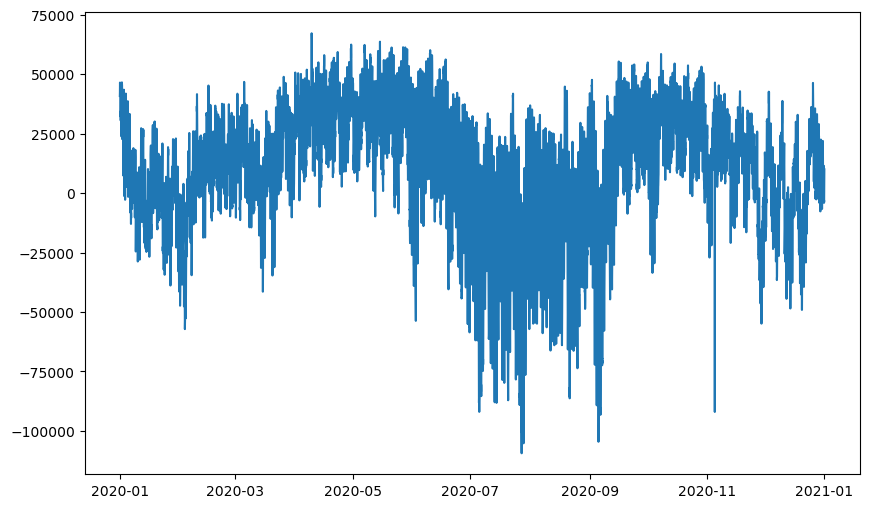

In [78]:

import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10, 6))
plt.plot(df_stoc['excess'])

<Axes: xlabel='time'>

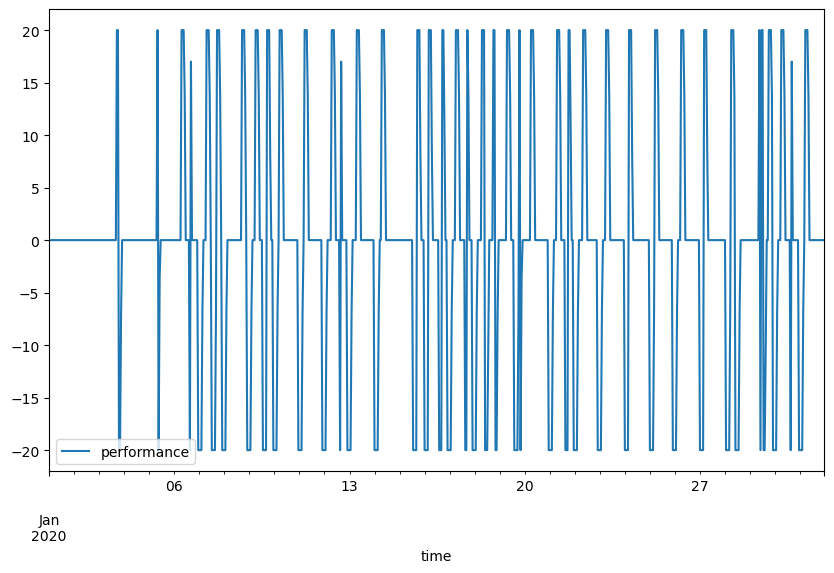

In [32]:
storage_performance = simulation.unit_performance["StorageUnit"]
storage_performance
all_performance = storage_performance.sel(energy_unit = slice(0, None))

specific_performance = storage_performance.sel(energy_unit = 1)
specific_performance.to_dataframe(name = 'performance').reset_index()
#convert to dataframe
#plot the dataframe for just january
specific_performance = specific_performance.sel(time=slice("2020-01-01", "2020-01-31"))
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10, 6))
specific_performance.to_dataframe(name = 'performance').reset_index().plot(x='time', y='performance', ax=ax)

The ProbabilisticSimulation object generates a net hourly capacity matrix, representing net system capacity in each Monte Carlo trial. We can access a copy of this matrix to analyze shortfalls.

In [81]:
# convert net hourly capacity matrix to pandas dataframe with risk hours only
shortfall_matrix_pd = simulation.net_hourly_capacity_matrix.where(lambda c: c < 0).to_pandas().T.dropna(how="all")
shortfall_matrix_pd

trial,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
time,,,,,,,,,,,,,,,
2020-01-03 10:00:00,NaN,-2.273737e-13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-03 11:00:00,NaN,-2.045264e+03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-3124.853021,NaN,NaN,NaN
2020-01-03 12:00:00,NaN,NaN,NaN,NaN,NaN,NaN,-3582.691959,NaN,NaN,NaN,NaN,NaN,-1915.581059,NaN,NaN
2020-01-03 17:00:00,-3180.379934,-4.066809e+03,-5983.789796,-3725.379962,-2912.093707,-3992.659884,-3260.804662,-7771.006344,-3265.464304,-6459.640125,-6082.866463,-1135.836028,-5548.664381,-2467.203606,-3143.732077
2020-01-03 18:00:00,-6014.283939,-8.589145e+03,-6376.382654,NaN,-9304.331200,-3301.450732,-6620.379497,-12218.587749,-7202.916599,-11070.745784,-5519.770709,-6908.633295,-8282.765335,-3475.339205,-4171.922279
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-31 17:00:00,-11168.340038,-1.063730e+04,-7745.088236,-12137.168463,-8832.770139,-6735.545165,-11052.323195,-9577.682381,-8865.673040,-6246.069801,-7262.879127,-11844.791963,-5689.342229,-14315.590969,-10056.935536
2020-12-31 18:00:00,-8939.946469,-9.948925e+03,-10104.438170,-11302.458038,-12192.900832,-9334.095076,-13224.779450,-20838.476416,-7824.645419,-8219.626375,-8058.150181,-16725.577278,-14051.894494,-13430.423778,-17492.477500
2020-12-31 19:00:00,-4948.780286,-1.409927e+04,-5131.157758,-10547.632328,-7005.153414,-6720.140909,-9251.226189,-9915.074322,-11342.347463,-9949.962478,-8013.163817,-7035.572935,-5237.571352,-11078.592089,-9559.863942



We can calculate hourly loss of load probability from the net hourly capacity matrix

In [82]:
# get loss of load probability
loss_of_load_prob = shortfall_matrix_pd.count(axis=1) / shortfall_matrix_pd.shape[1]

# show top 10 risk hours
loss_of_load_prob.sort_values(ascending=False)[:10]

time
2020-07-23 22:00:00    1.0
2020-08-11 14:00:00    1.0
2020-08-12 23:00:00    1.0
2020-08-13 00:00:00    1.0
2020-08-13 09:00:00    1.0
2020-08-13 10:00:00    1.0
2020-08-13 11:00:00    1.0
2020-08-13 12:00:00    1.0
2020-08-13 13:00:00    1.0
2020-08-13 14:00:00    1.0
dtype: float64

In [83]:
from assetra.metrics import ExpectedUnservedEnergy

# instantiate eue model
eue_model = ExpectedUnservedEnergy(simulation)
eue = eue_model.evaluate()

print("System EUE:", round(eue, 2), "MWh")

System EUE: 139775486.16 MWh


In [84]:
from assetra.metrics import LossOfLoadHours, LossOfLoadDays, LossOfLoadFrequency
import pandas as pd

adequacy = pd.Series(dtype=float)

for name, metric in [
    ("EUE (MWh)", ExpectedUnservedEnergy),
    ("LOLH (h)", LossOfLoadHours),
    ("LOLD (d)", LossOfLoadDays),
    ("LOLF (#)", LossOfLoadFrequency)
]:
    adequacy[name] = metric(simulation).evaluate()

# show results
adequacy.round(1)

EUE (MWh)    139775486.2
LOLH (h)          2826.1
LOLD (d)           236.9
LOLF (#)           271.1
dtype: float64

In [85]:
adequacy["Average Outage Duration (h)"] = adequacy["LOLH (h)"] / adequacy["LOLF (#)"]
adequacy["Average Shortfall (MW)"] = adequacy["EUE (MWh)"] / adequacy["LOLH (h)"]

# show results
adequacy.round(1)


EUE (MWh)                      139775486.2
LOLH (h)                            2826.1
LOLD (d)                             236.9
LOLF (#)                             271.1
Average Outage Duration (h)           10.4
Average Shortfall (MW)             49458.2
dtype: float64

Quantify resource contribution (ELCC)

Resource contribution is a typical extension of resource adequacy analysis. The assetra package implements effective load-carrying capability (ELCC) to quantify resource contribution. When we instantiate an EffectiveLoadCarryingCapability object, the base system will automatically be evaluated according to the ResourceAdequacyMetric type we provide. In the following example, we indicate that resource adequacy should be defined as EUE (e.g. rather than LOLH) by passing ExpectedUnservedEnergy (the class not an instance) as the last parameter to the ELCC instance.


In [ ]:
id=99999,
nameplate_capacity=10,
charge_rate=nameplate_capacity
discharge_rate=nameplate_capacity
charge_capacity=nameplate_capacity * 4
roundtrip_efficiency=.85
storage_duration = charge_capacity / nameplate_capacity
storage_class = '4'  


In [86]:
builder = EnergySystemBuilder()
builder.add_unit(
    StorageUnit(
        id=99999,
        nameplate_capacity=10,
        charge_rate=10,
        discharge_rate=10,
        charge_capacity=10 * 4,
        roundtrip_efficiency=.85,
        storage_duration = 40 / 10,
        storage_class = '4'  
    )
    
)
 # add unit to energy system
additional_system = builder.build()

In [87]:
additional_system.system_capacity

10.0

In [89]:
from assetra.contribution import EffectiveLoadCarryingCapability
from assetra.simulation import ProbabilisticSimulation
from assetra.metrics import ExpectedUnservedEnergy

# initialize elcc model
elcc_model = EffectiveLoadCarryingCapability(
    energy_system,
    ProbabilisticSimulation(
        start_hour="2020-01-01 00:00:00",
        end_hour="2020-12-31 23:00:00",
        trial_size=10
    ),
    ExpectedUnservedEnergy
)


In [90]:
elcc = elcc_model.evaluate(additional_system)
elcc_pct = elcc / additional_system.system_capacity * 100
elcc_pct

58.203125